<a href="https://colab.research.google.com/github/Thiraput01/NLP-sys/blob/main/Week%2010/Lab10_RAG_toStudent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install -qU langchain
!pip install -qU langchain-google-genai
!pip install -qU langchain-huggingface
!pip install -qU langchain-qdrant
!pip install -qU langchain-community
!pip install -qU langgraph
!pip install fastembed
!pip install datasets
# !pip install -U "fsspec[http]==2024.10.0"

# Code

In this assignment, you will need to set up and use
1. LangSmith to monitor your agent.
2. Use hybrid search to improve your retriever
3. Use a reranker to improve your search result.



## TODO 0: Set up LangSmith

Create a LangSmith account and set up tracing for this assignment. https://www.smith.langchain.com/.

No need to configure, just add your LangSmith API key.

In [2]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('gemini_api_key')
os.environ["LANGSMITH_API_KEY"] = userdata.get('langsmith_api_key')
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Components

We will be using Gemini as our LLM. Feel free to try out others if you want.

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

For our sentence embeddings, we will use [ModernBERT](https://arxiv.org/abs/2412.13663) trained by Alibaba as it is small and performant.

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

model_kwargs = {'trust_remote_code': True}
embeddings = HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-modernbert-base",model_kwargs=model_kwargs)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Likewise, the reranker is also based on the ModernBERT trained by Alibaba.

In [5]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="Alibaba-NLP/gte-reranker-modernbert-base")

For our dataset, we will be using SQuAD v2 dataset.

In [6]:
import datasets

ds = datasets.load_dataset("rajpurkar/squad_v2", split="validation")

## Indexing

In [7]:
from langchain_core.documents import Document

In [8]:
all_docs = [Document(text) for text in  list(set(ds["context"]))]
print(len(all_docs))

1204


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(all_docs)

print(f"Split wiki abstract into {len(all_splits)} sub-documents.")

Split wiki abstract into 1222 sub-documents.


## TODO 1: Hybrid Search
Embed your documents in a vector database that supports hybrid search. Also set the retrieval mode to hybrid search. Use BM25 as the lexical search.

Hint: read more on `QdrantVectorStore` [here](https://python.langchain.com/api_reference/qdrant/qdrant/langchain_qdrant.qdrant.QdrantVectorStore.html#langchain_qdrant.qdrant.QdrantVectorStore). (You can use any vector DB that can do hybrid search)

In [13]:
from langchain_qdrant import FastEmbedSparse, QdrantVectorStore, RetrievalMode
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import Distance, SparseVectorParams, VectorParams

sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

client = QdrantClient(path="/tmp/langchain_qdrant")

client.create_collection(
    collection_name="my_documents",
    vectors_config={"dense": VectorParams(size=768, distance=Distance.COSINE)},
    sparse_vectors_config={
        "sparse": SparseVectorParams(index=models.SparseIndexParams(on_disk=False))
    },
)

RuntimeError: Storage folder /tmp/langchain_qdrant is already accessed by another instance of Qdrant client. If you require concurrent access, use Qdrant server instead.

In [14]:
# retriever
qdrant = QdrantVectorStore(
    client=client,
    collection_name="my_documents",
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    retrieval_mode=RetrievalMode.HYBRID,
    vector_name="dense",
    sparse_vector_name="sparse",
)

qdrant.add_documents(documents=all_splits)

['dfc50757cbf644a6867c6a63bc597b20',
 '903f655bcd54495f997da75a082444f1',
 'f40fbaaa41d44306af4e4b8bb0bb6940',
 '47cd089e28f44944bf1a5993ec98ab25',
 '62fe52587f52497b9717af2d36f67212',
 '37733d4ee7c74f019819c849f47885c7',
 '6c34a9d98ac34c288a87a8cd2aff2ca8',
 'c774edf9f8d44d34b861565f63d21b1b',
 '0095bc109380461f85b16710647251f1',
 '94173dabdf15450fb0486b0d549c4a00',
 'df55448ce7464dcfaac1f4447bfe760c',
 '95c4aff78b7a40f287bb376488d0bc69',
 '5d4cacf830c04e63814b6f7c399fa5b7',
 'b27acac45cff4377aefe76c798c0028e',
 'fcc82149e8394eaa85f5eee1774177d9',
 '4a7901d144f841aa95d31398e6b7c5ab',
 'fbd6c5fdd07949a394fb02a05cae0f86',
 'be1bdd13c4404547b69e3528592bd56f',
 '3b0d45ca19f54ceb9cc3d1dc4c149479',
 'f7e2f5c484f3436c8df76ada60ff6805',
 'a30d324592c242d5bbf6380b5ddfa301',
 'c17dcb9d58c14309ad02f399d59eacff',
 '8f08fc7218ae40af86f7db5123688b93',
 '3808232ed9f244789e6c82a1a59e137d',
 '15b8e720ae65439f837bd0c23b8e3d5d',
 '511b7db0ba5c48628e3d2a4f1fd5f650',
 '70256752dd384e10be17d67a9a368c33',
 

In [15]:
all_splits[0]

Document(metadata={'start_index': 0}, page_content='Before the actual research explicitly devoted to the complexity of algorithmic problems started off, numerous foundations were laid out by various researchers. Most influential among these was the definition of Turing machines by Alan Turing in 1936, which turned out to be a very robust and flexible simplification of a computer.')

In [16]:
query = "When were the Normans in Normandy?"
found_docs = qdrant.similarity_search(query)

In [17]:
for d in found_docs:
  print(d)

page_content='The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.' metadata={'start_index': 0, '_id': 'db2cc30373ec4057afbf9650a3acd512', '_collection_name': 'my_documents'}
page_content='The Normans thereafter adopted the growing feudal doctrines of the rest of France, and worked them into a functional hier

In [18]:
context = "\n".join([doc.page_content for doc in found_docs])

input_text = f"Context:\n{context}\n\nQuestion: {query}\n\nAnswer:"
response = llm.predict(input_text)
response

<ipython-input-18-8e0f63bae8c2>:4: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm.predict(input_text)


'The Normans were in Normandy in the 10th and 11th centuries.'

## TODO 2: Reranking

Create two retrievers.
1. A normal retriever without a reranker. Set the `top_k` to 20.
2. A retriever with a reranker. Set the `top_k` of the reranker to 3.


In [19]:
# 1.
retriever = qdrant.as_retriever(search_kwargs={"k": 20})

In [20]:
from langchain.retrievers import ContextualCompressionRetriever

# 2.
reranker = CrossEncoderReranker(
    model = model,
    top_n = 3
)

retriever_reranked = ContextualCompressionRetriever(
    base_retriever=retriever,
    base_compressor=reranker
)

In [21]:
query = "When were the Normans in Normandy?"
found_docs = retriever.get_relevant_documents(query)

for d in found_docs:
  print(d)

page_content='The Normans thereafter adopted the growing feudal doctrines of the rest of France, and worked them into a functional hierarchical system in both Normandy and in England. The new Norman rulers were culturally and ethnically distinct from the old French aristocracy, most of whom traced their lineage to Franks of the Carolingian dynasty. Most Norman knights remained poor and land-hungry, and by 1066 Normandy had been exporting fighting horsemen for more than a generation. Many Normans of Italy, France and England eventually served as avid Crusaders under the Italo-Norman prince Bohemund I and the Anglo-Norman king Richard the Lion-Heart.' metadata={'start_index': 0, '_id': '68005cd470414876985df4461c5d853e', '_collection_name': 'my_documents'}
page_content='The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "N

<ipython-input-21-3ae728c1f69b>:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  found_docs = retriever.get_relevant_documents(query)


In [22]:
query = "When were the Normans in Normandy?"
found_docs = retriever_reranked.get_relevant_documents(query)

for d in found_docs:
  print(d)

page_content='The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.' metadata={'start_index': 0, '_id': '651b1085c4d946c486907809189fbe87', '_collection_name': 'my_documents'}
page_content='The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gav

Take a subset of the dataset to evaluate the MRR of the retrievers.

In [23]:
sample = ds.take(1000)

## TODO 3: Retrieval Evaluation

Calculate the MRR of the two retrievers based on the top 3 returned by each retriever.

**For the vanilla retriever (no reranker), take only the top-3 to evaluate the MRR and ignore the rest.**

In [63]:
from tqdm import tqdm

no_rerank = no_rerank_failures = 0
limit = -1
count = 0

for row in tqdm(sample):
    query = row["question"]
    # answer = row["answers"]["text"]
    context = row["context"]

    res_mmr = retriever.invoke(query)
    found = False
    for i in range(3):
        doc_content = res_mmr[i].page_content
        if doc_content == context:
            no_rerank += 1/(i+1)
            found = True
            break
    if not found:
        print(f"Query {count}: Failed to find relevant doc in top 3 results")
        no_rerank_failures += 1

    count += 1
    if limit != -1 and count == limit:
        break

  1%|          | 8/1000 [00:00<01:49,  9.02it/s]

Query 6: Failed to find relevant doc in top 3 results


  2%|▏         | 16/1000 [00:01<01:51,  8.84it/s]

Query 14: Failed to find relevant doc in top 3 results
Query 15: Failed to find relevant doc in top 3 results


  3%|▎         | 34/1000 [00:03<01:43,  9.33it/s]

Query 32: Failed to find relevant doc in top 3 results


  6%|▌         | 57/1000 [00:06<01:37,  9.64it/s]

Query 56: Failed to find relevant doc in top 3 results


  6%|▋         | 63/1000 [00:07<01:38,  9.47it/s]

Query 61: Failed to find relevant doc in top 3 results


  7%|▋         | 70/1000 [00:07<01:41,  9.14it/s]

Query 68: Failed to find relevant doc in top 3 results


  7%|▋         | 74/1000 [00:08<01:48,  8.56it/s]

Query 72: Failed to find relevant doc in top 3 results


 10%|█         | 102/1000 [00:12<02:16,  6.57it/s]

Query 100: Failed to find relevant doc in top 3 results


 11%|█         | 112/1000 [00:13<01:43,  8.58it/s]

Query 110: Failed to find relevant doc in top 3 results


 12%|█▏        | 115/1000 [00:13<01:39,  8.89it/s]

Query 113: Failed to find relevant doc in top 3 results


 14%|█▎        | 137/1000 [00:16<01:42,  8.41it/s]

Query 135: Failed to find relevant doc in top 3 results


 14%|█▍        | 139/1000 [00:16<01:40,  8.55it/s]

Query 137: Failed to find relevant doc in top 3 results


 15%|█▌        | 154/1000 [00:18<01:35,  8.89it/s]

Query 152: Failed to find relevant doc in top 3 results


 16%|█▌        | 158/1000 [00:18<01:34,  8.94it/s]

Query 156: Failed to find relevant doc in top 3 results


 16%|█▋        | 165/1000 [00:19<01:33,  8.93it/s]

Query 163: Failed to find relevant doc in top 3 results


 17%|█▋        | 172/1000 [00:20<01:32,  8.93it/s]

Query 170: Failed to find relevant doc in top 3 results


 19%|█▊        | 187/1000 [00:21<01:36,  8.40it/s]

Query 185: Failed to find relevant doc in top 3 results


 19%|█▉        | 190/1000 [00:22<01:41,  7.97it/s]

Query 188: Failed to find relevant doc in top 3 results
Query 189: Failed to find relevant doc in top 3 results


 20%|██        | 203/1000 [00:24<02:19,  5.73it/s]

Query 202: Failed to find relevant doc in top 3 results


 25%|██▍       | 249/1000 [00:30<01:41,  7.38it/s]

Query 247: Failed to find relevant doc in top 3 results


 26%|██▋       | 264/1000 [00:32<01:36,  7.63it/s]

Query 262: Failed to find relevant doc in top 3 results


 27%|██▋       | 269/1000 [00:33<01:32,  7.87it/s]

Query 267: Failed to find relevant doc in top 3 results


 30%|███       | 302/1000 [00:39<02:02,  5.71it/s]

Query 300: Failed to find relevant doc in top 3 results


 32%|███▏      | 315/1000 [00:42<01:35,  7.19it/s]

Query 313: Failed to find relevant doc in top 3 results


 32%|███▏      | 324/1000 [00:43<01:17,  8.71it/s]

Query 322: Failed to find relevant doc in top 3 results


 38%|███▊      | 379/1000 [00:51<01:13,  8.44it/s]

Query 377: Failed to find relevant doc in top 3 results


 38%|███▊      | 383/1000 [00:52<01:15,  8.16it/s]

Query 381: Failed to find relevant doc in top 3 results


 43%|████▎     | 433/1000 [00:58<01:11,  7.93it/s]

Query 431: Failed to find relevant doc in top 3 results


 47%|████▋     | 467/1000 [01:03<01:06,  7.97it/s]

Query 465: Failed to find relevant doc in top 3 results


 48%|████▊     | 482/1000 [01:05<01:02,  8.28it/s]

Query 480: Failed to find relevant doc in top 3 results


 50%|█████     | 505/1000 [01:07<01:01,  8.11it/s]

Query 503: Failed to find relevant doc in top 3 results


 52%|█████▏    | 520/1000 [01:09<01:02,  7.68it/s]

Query 518: Failed to find relevant doc in top 3 results


 53%|█████▎    | 530/1000 [01:11<00:59,  7.93it/s]

Query 528: Failed to find relevant doc in top 3 results


 54%|█████▍    | 540/1000 [01:12<00:57,  7.96it/s]

Query 538: Failed to find relevant doc in top 3 results


 55%|█████▍    | 545/1000 [01:13<01:04,  7.00it/s]

Query 544: Failed to find relevant doc in top 3 results


 56%|█████▌    | 555/1000 [01:15<01:21,  5.45it/s]

Query 553: Failed to find relevant doc in top 3 results
Query 554: Failed to find relevant doc in top 3 results


 58%|█████▊    | 583/1000 [01:18<00:52,  7.89it/s]

Query 581: Failed to find relevant doc in top 3 results


 59%|█████▉    | 591/1000 [01:19<00:50,  8.18it/s]

Query 589: Failed to find relevant doc in top 3 results


 63%|██████▎   | 632/1000 [01:24<00:43,  8.39it/s]

Query 630: Failed to find relevant doc in top 3 results


 64%|██████▍   | 644/1000 [01:26<00:59,  6.00it/s]

Query 642: Failed to find relevant doc in top 3 results


 65%|██████▌   | 650/1000 [01:27<01:00,  5.77it/s]

Query 648: Failed to find relevant doc in top 3 results


 65%|██████▌   | 652/1000 [01:27<01:03,  5.47it/s]

Query 650: Failed to find relevant doc in top 3 results
Query 651: Failed to find relevant doc in top 3 results


 67%|██████▋   | 674/1000 [01:30<00:34,  9.44it/s]

Query 671: Failed to find relevant doc in top 3 results


 68%|██████▊   | 678/1000 [01:30<00:36,  8.82it/s]

Query 676: Failed to find relevant doc in top 3 results


 72%|███████▏  | 715/1000 [01:34<00:31,  8.99it/s]

Query 713: Failed to find relevant doc in top 3 results


 72%|███████▏  | 720/1000 [01:35<00:30,  9.12it/s]

Query 718: Failed to find relevant doc in top 3 results


 72%|███████▏  | 722/1000 [01:35<00:31,  8.80it/s]

Query 720: Failed to find relevant doc in top 3 results


 73%|███████▎  | 727/1000 [01:36<00:27,  9.84it/s]

Query 725: Failed to find relevant doc in top 3 results


 76%|███████▌  | 761/1000 [01:40<00:28,  8.32it/s]

Query 759: Failed to find relevant doc in top 3 results


 77%|███████▋  | 767/1000 [01:41<00:27,  8.46it/s]

Query 765: Failed to find relevant doc in top 3 results


 77%|███████▋  | 769/1000 [01:41<00:28,  8.13it/s]

Query 767: Failed to find relevant doc in top 3 results


 78%|███████▊  | 778/1000 [01:43<00:27,  8.06it/s]

Query 776: Failed to find relevant doc in top 3 results


 80%|███████▉  | 799/1000 [01:45<00:26,  7.62it/s]

Query 797: Failed to find relevant doc in top 3 results


 81%|████████  | 811/1000 [01:47<00:22,  8.27it/s]

Query 809: Failed to find relevant doc in top 3 results


 82%|████████▏ | 816/1000 [01:47<00:23,  7.81it/s]

Query 814: Failed to find relevant doc in top 3 results


 84%|████████▍ | 842/1000 [01:51<00:27,  5.84it/s]

Query 840: Failed to find relevant doc in top 3 results


 85%|████████▍ | 846/1000 [01:52<00:29,  5.29it/s]

Query 844: Failed to find relevant doc in top 3 results
Query 845: Failed to find relevant doc in top 3 results


 86%|████████▌ | 859/1000 [01:53<00:17,  8.18it/s]

Query 857: Failed to find relevant doc in top 3 results


 91%|█████████ | 907/1000 [01:59<00:10,  8.65it/s]

Query 905: Failed to find relevant doc in top 3 results


 94%|█████████▍| 944/1000 [02:04<00:10,  5.56it/s]

Query 942: Failed to find relevant doc in top 3 results
Query 943: Failed to find relevant doc in top 3 results


 97%|█████████▋| 968/1000 [02:07<00:03,  8.28it/s]

Query 966: Failed to find relevant doc in top 3 results


 99%|█████████▊| 986/1000 [02:09<00:01,  7.95it/s]

Query 984: Failed to find relevant doc in top 3 results


100%|██████████| 1000/1000 [02:11<00:00,  7.60it/s]


In [94]:
rerank = rerank_failures = 0
limit = -1
count = 0

for row in tqdm(sample):
    query = row["question"]
    # answer = row["answers"]["text"]
    context = row["context"]

    res_mmr = retriever_reranked.invoke(query)
    found = False
    for i in range(3):
        doc_content = res_mmr[i].page_content
        if doc_content == context:
            rerank += 1/(i+1)
            found = True
            break
    if not found:
        print(f"Query {count}: Failed to find relevant doc in top 3 results")
        rerank_failures += 1

    count += 1
    if limit != -1 and count == limit:
        break

  2%|▏         | 16/1000 [00:10<10:03,  1.63it/s]

Query 15: Failed to find relevant doc in top 3 results


  6%|▌         | 62/1000 [00:39<10:16,  1.52it/s]

Query 61: Failed to find relevant doc in top 3 results


 10%|█         | 101/1000 [01:05<09:36,  1.56it/s]

Query 100: Failed to find relevant doc in top 3 results


 11%|█         | 111/1000 [01:12<10:18,  1.44it/s]

Query 110: Failed to find relevant doc in top 3 results


 14%|█▍        | 138/1000 [01:29<09:51,  1.46it/s]

Query 137: Failed to find relevant doc in top 3 results


 16%|█▌        | 157/1000 [01:43<10:33,  1.33it/s]

Query 156: Failed to find relevant doc in top 3 results


 16%|█▌        | 162/1000 [01:46<10:09,  1.37it/s]

Query 161: Failed to find relevant doc in top 3 results


 17%|█▋        | 171/1000 [01:53<09:45,  1.42it/s]

Query 170: Failed to find relevant doc in top 3 results


 19%|█▊        | 186/1000 [02:03<09:02,  1.50it/s]

Query 185: Failed to find relevant doc in top 3 results


 24%|██▍       | 245/1000 [02:41<08:31,  1.48it/s]

Query 244: Failed to find relevant doc in top 3 results


 25%|██▍       | 248/1000 [02:43<07:43,  1.62it/s]

Query 247: Failed to find relevant doc in top 3 results


 36%|███▌      | 360/1000 [03:50<06:11,  1.72it/s]

Query 359: Failed to find relevant doc in top 3 results


 36%|███▋      | 364/1000 [03:52<06:39,  1.59it/s]

Query 363: Failed to find relevant doc in top 3 results


 38%|███▊      | 378/1000 [04:01<05:54,  1.75it/s]

Query 377: Failed to find relevant doc in top 3 results


 38%|███▊      | 382/1000 [04:03<05:27,  1.89it/s]

Query 381: Failed to find relevant doc in top 3 results


 41%|████      | 411/1000 [04:21<05:29,  1.79it/s]

Query 410: Failed to find relevant doc in top 3 results


 42%|████▏     | 415/1000 [04:24<05:27,  1.79it/s]

Query 414: Failed to find relevant doc in top 3 results


 48%|████▊     | 481/1000 [05:03<05:09,  1.68it/s]

Query 480: Failed to find relevant doc in top 3 results


 51%|█████     | 511/1000 [05:22<05:48,  1.40it/s]

Query 510: Failed to find relevant doc in top 3 results


 60%|██████    | 600/1000 [06:16<04:27,  1.49it/s]

Query 599: Failed to find relevant doc in top 3 results


 63%|██████▎   | 631/1000 [06:34<03:14,  1.90it/s]

Query 630: Failed to find relevant doc in top 3 results


 65%|██████▍   | 649/1000 [06:46<03:59,  1.46it/s]

Query 648: Failed to find relevant doc in top 3 results


 65%|██████▌   | 650/1000 [06:47<04:01,  1.45it/s]

Query 649: Failed to find relevant doc in top 3 results


 65%|██████▌   | 651/1000 [06:47<03:51,  1.51it/s]

Query 650: Failed to find relevant doc in top 3 results


 67%|██████▋   | 669/1000 [06:59<03:25,  1.61it/s]

Query 668: Failed to find relevant doc in top 3 results


 67%|██████▋   | 672/1000 [07:01<03:40,  1.49it/s]

Query 671: Failed to find relevant doc in top 3 results


 72%|███████▏  | 719/1000 [07:30<03:04,  1.52it/s]

Query 718: Failed to find relevant doc in top 3 results


 73%|███████▎  | 726/1000 [07:35<03:01,  1.51it/s]

Query 725: Failed to find relevant doc in top 3 results


 78%|███████▊  | 777/1000 [08:07<02:11,  1.69it/s]

Query 776: Failed to find relevant doc in top 3 results


 84%|████████▍ | 841/1000 [08:46<01:34,  1.69it/s]

Query 840: Failed to find relevant doc in top 3 results


 85%|████████▍ | 846/1000 [08:49<01:42,  1.50it/s]

Query 845: Failed to find relevant doc in top 3 results


 86%|████████▌ | 858/1000 [08:56<01:13,  1.93it/s]

Query 857: Failed to find relevant doc in top 3 results


 94%|█████████▍| 944/1000 [09:46<00:34,  1.61it/s]

Query 943: Failed to find relevant doc in top 3 results


100%|██████████| 1000/1000 [10:20<00:00,  1.61it/s]


In [96]:
print(f"MRR of the retriever without a reranker: {no_rerank / len(sample):.4f}")
print(f"MRR of the retriever with a reranker: {rerank / len(sample):.4f}")

print(f"Percentage of queries with no relevant doc in top 3 (no rerank): {100 * no_rerank_failures / len(sample):.2f}%")
print(f"Percentage of queries with no relevant doc in top 3 (rerank): {100 * rerank_failures / len(sample):.2f}%")

MRR of the retriever without a reranker: 1.7870
MRR of the retriever with a reranker: 0.9342
Percentage of queries with no relevant doc in top 3 (no rerank): 10.10%
Percentage of queries with no relevant doc in top 3 (rerank): 3.30%


## Agentic RAG

Feel free to use the workflow from the demo. However, you will need to modify it slightly to use the retriever with a reranker.

## TODO 4: Usage
Run your agent twice. Once on a message that doesn't need tool-use like "hello" and again for a message that does.

In [24]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [25]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query from a vector database containing information on student's handbook."""
    retrieved_docs = retriever_reranked.get_relevant_documents(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [26]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
# The ToolNode is roughly analogous to:

# tools_by_name = {tool.name: tool for tool in tools}
# def tool_node(state: dict):
#     result = []
#     for tool_call in state["messages"][-1].tool_calls:
#         tool = tools_by_name[tool_call["name"]]
#         observation = tool.invoke(tool_call["args"])
#         result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
#     return {"messages": result}

tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [27]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

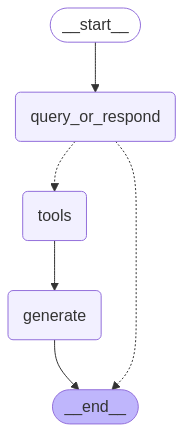

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [30]:
input_message = "hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [31]:
print('ahe9fodies')

ahe9fodies


In [32]:
input_message = "When were the Normans in Normandy?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

When were the Normans in Normandy?
================================== Ai Message ==================================
Tool Calls:
  retrieve (cba4b994-1c23-4aa6-ba86-5ec3ac6dfda7)
 Call ID: cba4b994-1c23-4aa6-ba86-5ec3ac6dfda7
  Args:
    query: When were the Normans in Normandy?
================================= Tool Message =================================
Name: retrieve

Source: {'start_index': 0, '_id': '651b1085c4d946c486907809189fbe87', '_collection_name': 'my_documents'}
Content: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with 

## TODO 5: Monitor your agent in LangSmith.

If you have set up correctly, you can just visit the LangSmith website and see that your tracings are logged into your LangSmith project.

Capture your screen like this and upload it to MCV.

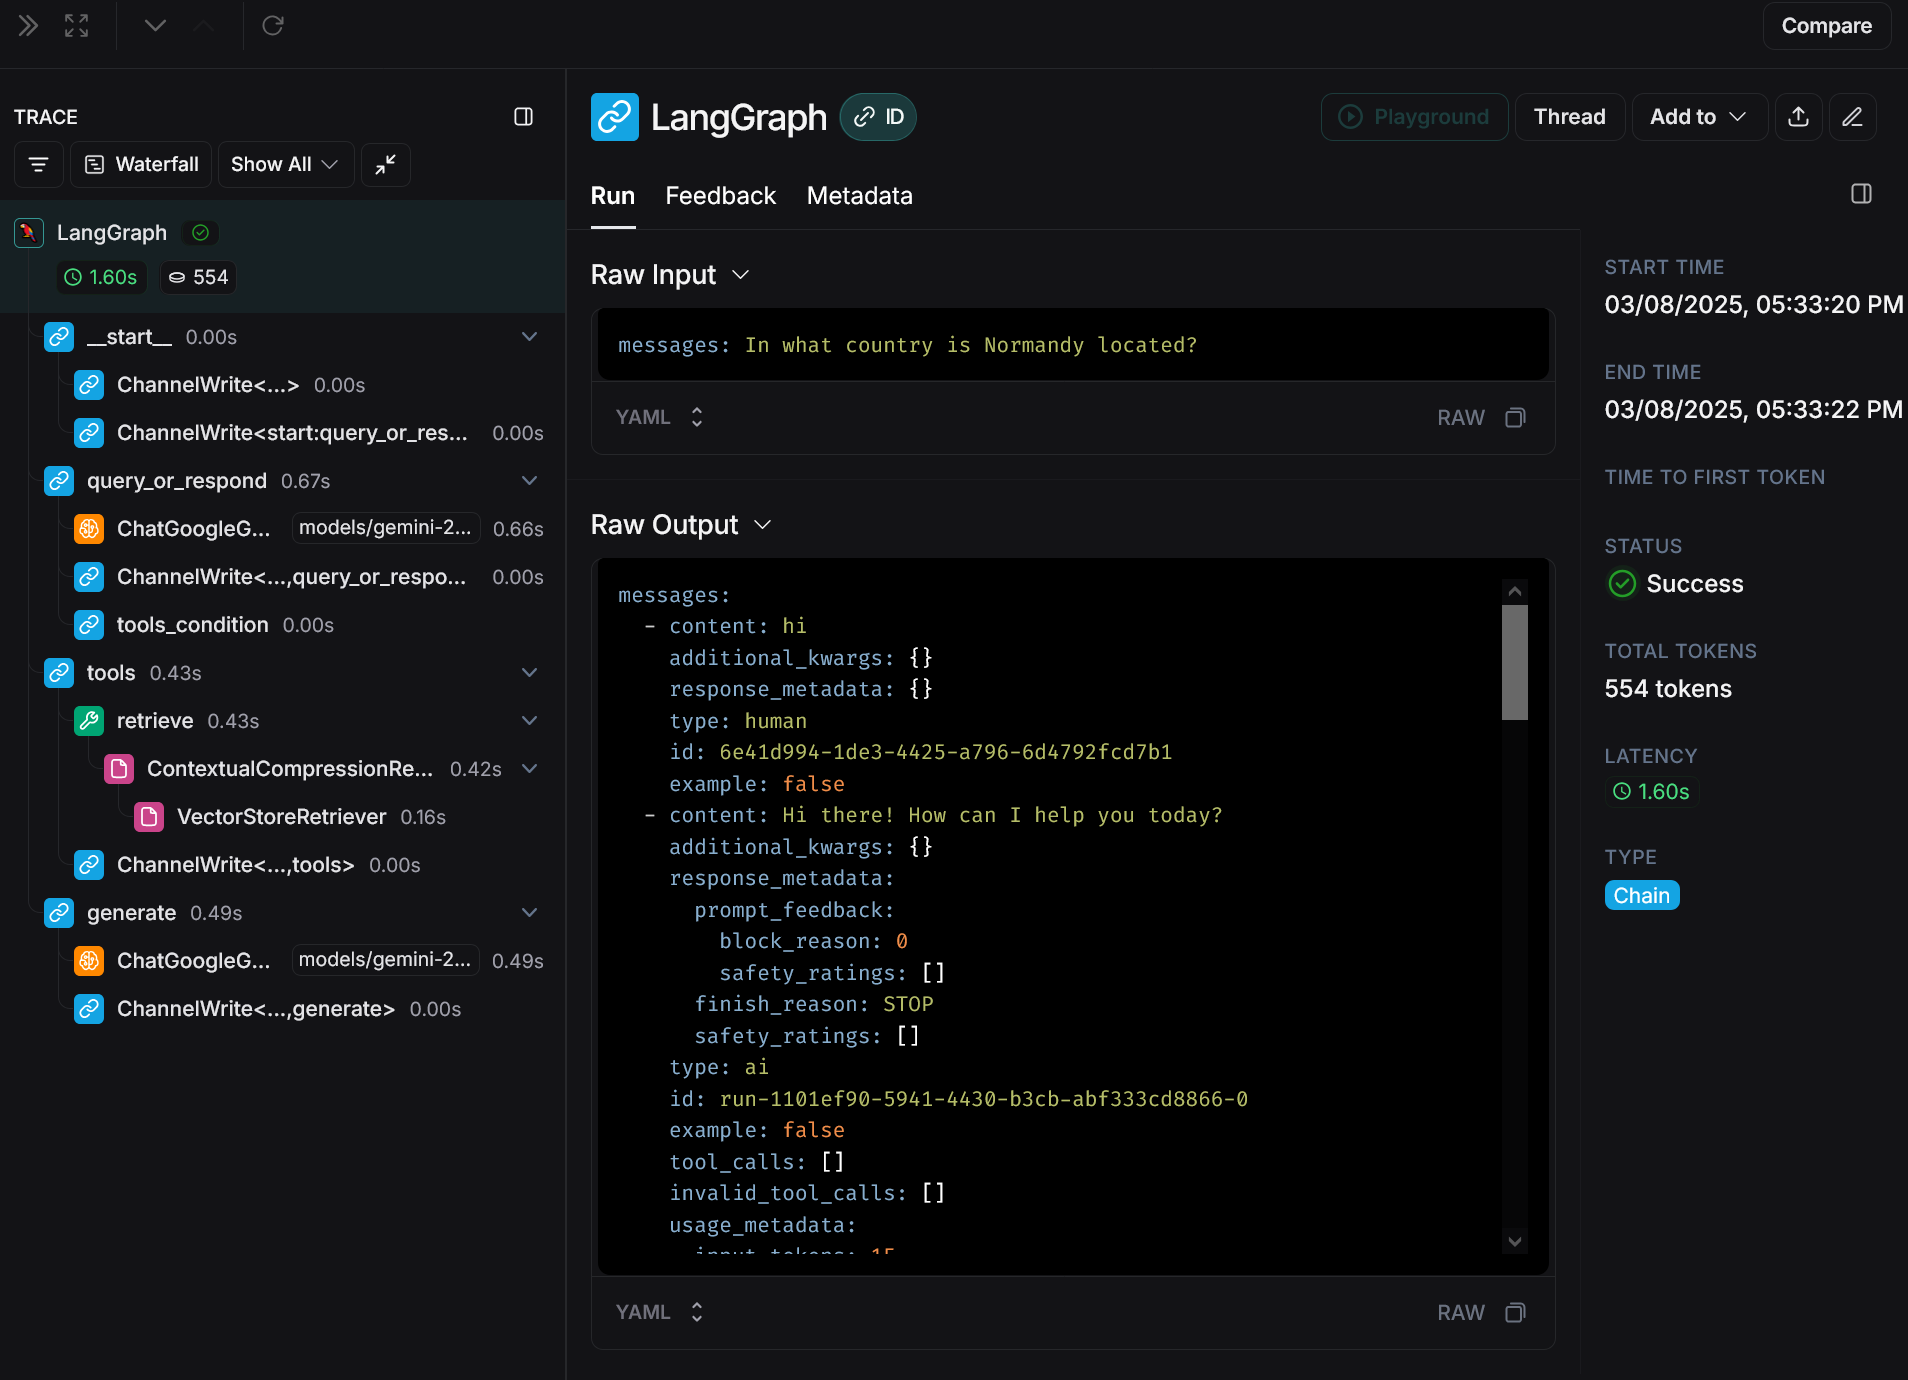

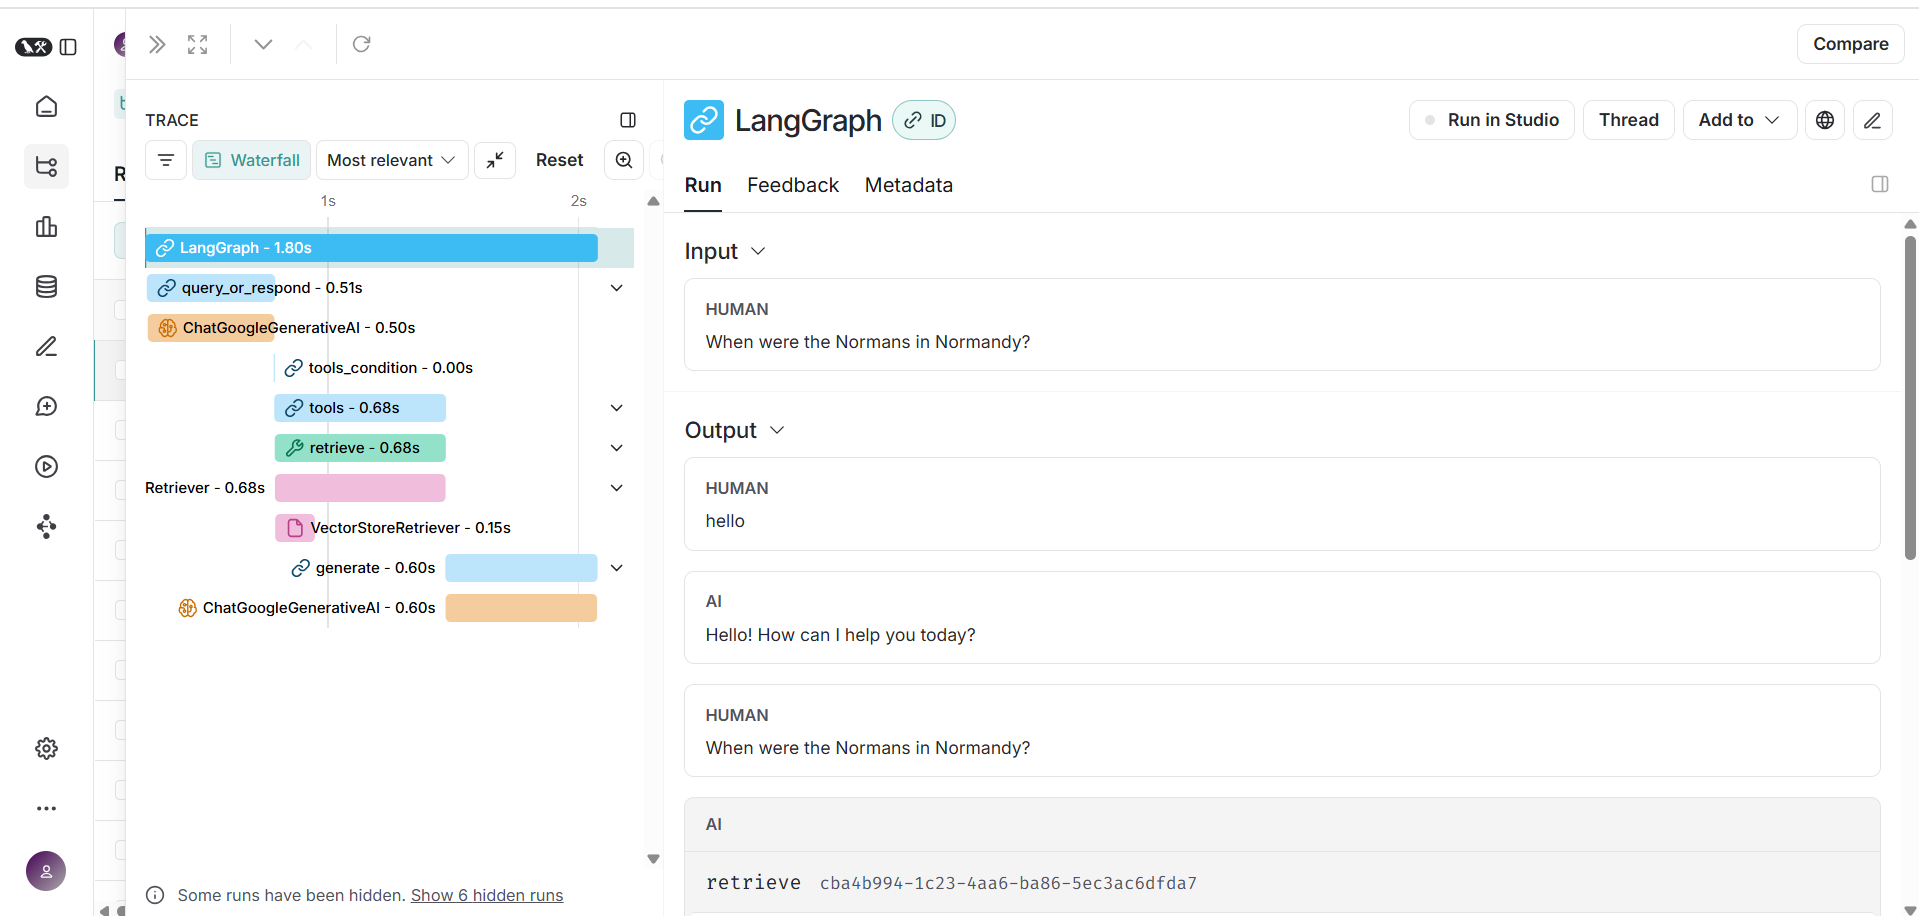